In [22]:
import numpy as np
import pandas as pd
import yahoofinancials as yf
from yahoofinancials import YahooFinancials
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import time
from fuzzywuzzy import fuzz
import pickle
import random

plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras import optimizers
from sklearn.metrics import mean_squared_error

## Model fitting with service industry

In [193]:
df = pd.read_csv('./temp_datalab_records_linkedin_company.csv');

In [194]:
service = ['Restaurants', 'Insurance', 'Financial Services', 'Media Production', 'Supermarkets',
           'Pharmaceuticals', 'Health, Wellness and Fitness', 'Airlines/Aviation', 'Banking','Investment Banking',
           'Construction', 'Facilities Services','Investment Management', 'Accounting', 'Retail', 
           'Consumer Services', 'Gambling & Casinos', ]
product = ['Consumer Electronics','Food Production','Utilities','Semiconductors',
            'Computer Networking','Medical Devices','Computer Games','Computer Software',
           'Sporting Goods', 'Glass, Ceramics & Concrete', 'Computer Hardware', 'Building Materials',
          'Furniture','Mining &amp; Metals',  'Luxury Goods & Jewelry', 'Wine and Spirits', 'Farming']

#['Marketing and Advertising','Wholesale','Commercial Real Estate','Online Media',
#'Publishing', 'Law Enforcement', 'Nanotechnology', 'Writing and Editing', 'Investment Banking']
df['industry'].unique();

In [195]:
# https://machinelearningmastery.com/how-to-scale-data-for-long-short-term-memory-networks-in-python/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.fillna(0, inplace=True)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [196]:
def split(values, n_in, n_train, n_valid):
    
    train = values[:n_train, :]
    valid = values[n_train:n_train+n_valid, :]
    test  = values[n_train+n_valid:, :]
    ftrain = values[:n_train+n_valid, :]

    train_X, train_y = train[:, :-1], train[:, -1]
    valid_X, valid_y = valid[:, :-1], valid[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    ftrain_X, ftrain_y = ftrain[:, :-1], ftrain[:, -1]

    # reshape input to be 3D [samples, timesteps=n_in, features=2]
    train_X = train_X.reshape((train_X.shape[0], n_in, 2))
    valid_X = valid_X.reshape((valid_X.shape[0], n_in, 2))
    test_X = test_X.reshape((test_X.shape[0], n_in, 2))
    ftrain_X = ftrain_X.reshape((ftrain_X.shape[0], n_in, 2))
    return [[train_X, valid_X, test_X, ftrain_X], [train_y, valid_y, test_y, ftrain_y]]

In [13]:
comp_emply = pickle.load( open( "comp_emply_dic.p", "rb" ) )
comp_tick = pickle.load( open( "comp_tick_dic.p", "rb" ) )
fail = pickle.load( open( "comp_fail.p", "rb" ) )

In [15]:
stock_prices_dump = pickle.load( open( "stock_prices_dump.p", "rb" ) )
comp_prices = pickle.load( open( "comp_prices.p", "rb" ) )

Combine employment and stock price data for training.
As a comparison without employment data, an array of 1 is used as a placeholder.

In [197]:
final_names = []
data_set = {}
data_set0 = {}
for name, p in comp_prices.iteritems():
    emply = comp_emply[name][-80:]
    prices = comp_prices[name][-80:]
    if np.sum(np.isnan(emply)) == 0 and np.sum(np.isnan(prices)) == 0:
        final_names.append(name)
        X = np.array([prices, emply])
        X0= np.array([prices, [1.]*len(emply)])
        data_set[name] = X.transpose()
        data_set0[name] = X0.transpose()

print len(final_names)

1396


Split company names by product and serivice categories

In [198]:
'''
service_name = []
product_name = []
for name in final_names:
    df_i = df.loc[df['company_name'] == name]
    ya = df_i.industry.unique()
    if ya[0] in service:
        service_name.append(name)
    if ya[0] in product:
        product_name.append(name)''';

In [199]:
#pickle.dump([service_name, product_name], open( "serv_prod_name.p", "wb" ) )
service_name, product_name = pickle.load( open( "serv_prod_name.p", "rb" ) )
print len(service_name), len(product_name)

302 238


## Validation runs to tune hyperparameters

In [54]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model.add(Dropout(0.25))

model.add(LSTM(units=50))
model.add(Dropout(0.25))

model.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optm)

(75, 11)
Lannett Company (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 2s - loss: 0.3590 - val_loss: 0.0939
Epoch 2/2
 - 0s - loss: 0.3034 - val_loss: 0.0632
(75, 11)
Brookfield Asset Management (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.2831 - val_loss: 0.2124
Epoch 2/2
 - 0s - loss: 0.2207 - val_loss: 0.1456
(75, 11)
The Hanover Insurance Group (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0416 - val_loss: 0.1870
Epoch 2/2
 - 0s - loss: 0.0301 - val_loss: 0.1274
(75, 11)
Delta Air Lines (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0498 - val_loss: 0.0424
Epoch 2/2
 - 0s - loss: 0.0356 - val_loss: 0.0231
(75, 11)
Nasdaq (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0282 - val_loss: 0.0139
Epoch 2/2
 - 0s - lo

Epoch 2/2
 - 0s - loss: 0.0459 - val_loss: 0.0538
(75, 11)
Mylan (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0364 - val_loss: 0.0212
Epoch 2/2
 - 0s - loss: 0.0348 - val_loss: 0.0180
(75, 11)
Legg Mason (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0183 - val_loss: 0.0241
Epoch 2/2
 - 0s - loss: 0.0175 - val_loss: 0.0234
(75, 11)
AXIS Capital (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0258 - val_loss: 0.0142
Epoch 2/2
 - 0s - loss: 0.0240 - val_loss: 0.0143
(75, 11)
D.R. Horton (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0118 - val_loss: 0.0208
Epoch 2/2
 - 0s - loss: 0.0104 - val_loss: 0.0286
(75, 11)
The Wendy's Company (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0296 - val_loss: 0.0232
Epo

 - 0s - loss: 0.0237 - val_loss: 0.0103
Epoch 2/2
 - 0s - loss: 0.0184 - val_loss: 0.0079
(75, 11)
Chico's FAS, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0295 - val_loss: 0.0043
Epoch 2/2
 - 0s - loss: 0.0217 - val_loss: 0.0037
(75, 11)
Eaton Vance (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0194 - val_loss: 0.0211
Epoch 2/2
 - 0s - loss: 0.0190 - val_loss: 0.0206
(75, 11)
Bristol-Myers Squibb (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0239 - val_loss: 0.0398
Epoch 2/2
 - 0s - loss: 0.0186 - val_loss: 0.0281
(75, 11)
Sportsman's Warehouse (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0224 - val_loss: 0.0304
Epoch 2/2
 - 0s - loss: 0.0253 - val_loss: 0.0324
(75, 11)
Itaú Unibanco (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on

Epoch 2/2
 - 0s - loss: 0.0243 - val_loss: 0.0172
(75, 11)
MetLife (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0238 - val_loss: 0.0654
Epoch 2/2
 - 0s - loss: 0.0219 - val_loss: 0.0629
(75, 11)
Independent Bank (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0129 - val_loss: 0.0094
Epoch 2/2
 - 0s - loss: 0.0130 - val_loss: 0.0088
(75, 11)
Build-A-Bear Workshop (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0173 - val_loss: 0.0066
Epoch 2/2
 - 0s - loss: 0.0191 - val_loss: 0.0065
(75, 11)
Boston Private (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0310 - val_loss: 0.0115
Epoch 2/2
 - 0s - loss: 0.0385 - val_loss: 0.0113
(75, 11)
Party City (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0282 - val_loss:

(75, 11)
Best Buy (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0087 - val_loss: 0.0100
Epoch 2/2
 - 0s - loss: 0.0081 - val_loss: 0.0103
(75, 11)
Nomura (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0151 - val_loss: 0.0145
Epoch 2/2
 - 0s - loss: 0.0182 - val_loss: 0.0168
(75, 11)
F.N.B. Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0188 - val_loss: 0.0152
Epoch 2/2
 - 0s - loss: 0.0180 - val_loss: 0.0154
(75, 11)
ABM Industries (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0182 - val_loss: 0.0135
Epoch 2/2
 - 0s - loss: 0.0153 - val_loss: 0.0158
(75, 11)
WesBanco (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0177 - val_loss: 0.0054
Epoch 2/2
 - 0s - loss: 0.0188 - val_loss: 0.0052
(75, 1

 - 0s - loss: 0.0126 - val_loss: 0.0047
Epoch 2/2
 - 0s - loss: 0.0121 - val_loss: 0.0047
(75, 11)
Atlanticus (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0065 - val_loss: 0.0034
Epoch 2/2
 - 0s - loss: 0.0043 - val_loss: 0.0026
(75, 11)
Papa John's International (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0124 - val_loss: 0.0102
Epoch 2/2
 - 0s - loss: 0.0126 - val_loss: 0.0100
(75, 11)
Citi (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0103 - val_loss: 0.0171
Epoch 2/2
 - 0s - loss: 0.0145 - val_loss: 0.0138
(75, 11)
American River Bank (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0147 - val_loss: 0.0047
Epoch 2/2
 - 0s - loss: 0.0158 - val_loss: 0.0045
(75, 11)
Boot Barn (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epo

Epoch 2/2
 - 0s - loss: 0.0264 - val_loss: 0.0296
(75, 11)
Yum! Brands (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0070 - val_loss: 0.0121
Epoch 2/2
 - 0s - loss: 0.0065 - val_loss: 0.0123
(75, 11)
Barclays (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0165 - val_loss: 0.0233
Epoch 2/2
 - 0s - loss: 0.0158 - val_loss: 0.0237
(75, 11)
Achillion Pharmaceuticals, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0316 - val_loss: 0.0182
Epoch 2/2
 - 0s - loss: 0.0272 - val_loss: 0.0186
(75, 11)
The Medicines Company (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0127 - val_loss: 0.0048
Epoch 2/2
 - 0s - loss: 0.0146 - val_loss: 0.0051
(75, 11)
Green Dot Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - 

 - 0s - loss: 0.0218 - val_loss: 0.0335
Epoch 2/2
 - 0s - loss: 0.0206 - val_loss: 0.0286
(75, 11)
Starbucks (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0117 - val_loss: 0.0179
Epoch 2/2
 - 0s - loss: 0.0092 - val_loss: 0.0150
(75, 11)
Alleghany Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0196 - val_loss: 0.0349
Epoch 2/2
 - 0s - loss: 0.0182 - val_loss: 0.0363
(75, 11)
Arena Pharmaceuticals, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0050 - val_loss: 0.0146
Epoch 2/2
 - 0s - loss: 0.0045 - val_loss: 0.0174
(75, 11)
PriceSmart (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0245 - val_loss: 0.0214
Epoch 2/2
 - 0s - loss: 0.0226 - val_loss: 0.0220
(75, 11)
Five Below (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 s

 - 0s - loss: 0.0063 - val_loss: 0.0093
(75, 11)
Cavco Industries, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0024 - val_loss: 0.0018
Epoch 2/2
 - 0s - loss: 0.0029 - val_loss: 0.0019
(75, 11)
Jazz Pharmaceuticals (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0052 - val_loss: 0.0045
Epoch 2/2
 - 0s - loss: 0.0052 - val_loss: 0.0044
(75, 11)
CenterState Bank (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0058 - val_loss: 0.0036
Epoch 2/2
 - 0s - loss: 0.0050 - val_loss: 0.0035
(75, 11)
Primerica (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0096 - val_loss: 0.0127
Epoch 2/2
 - 0s - loss: 0.0097 - val_loss: 0.0103
(75, 11)
LightInTheBox (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0188 - val_los

(75, 11)
Ulta Beauty (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0143 - val_loss: 0.0089
Epoch 2/2
 - 0s - loss: 0.0115 - val_loss: 0.0096
(75, 11)
Manning & Napier (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0050 - val_loss: 0.0062
Epoch 2/2
 - 0s - loss: 0.0033 - val_loss: 0.0059
(75, 11)
KemPharm, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0033 - val_loss: 0.0084
Epoch 2/2
 - 0s - loss: 0.0044 - val_loss: 0.0098
(75, 11)
CorVel Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0066 - val_loss: 0.0049
Epoch 2/2
 - 0s - loss: 0.0057 - val_loss: 0.0046
(75, 11)
The Blackstone Group (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0120 - val_loss: 0.0168
Epoch 2/2
 - 0s - loss: 0.0128 

(75, 11)
Cass Information Systems (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0133 - val_loss: 0.0143
Epoch 2/2
 - 0s - loss: 0.0117 - val_loss: 0.0110
(75, 11)
Bank of Hawaii (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0191 - val_loss: 0.0167
Epoch 2/2
 - 0s - loss: 0.0210 - val_loss: 0.0157
(75, 11)
ACADIA Pharmaceuticals Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0095 - val_loss: 0.0065
Epoch 2/2
 - 0s - loss: 0.0099 - val_loss: 0.0063
(75, 11)
Euronet Worldwide (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0147 - val_loss: 0.0181
Epoch 2/2
 - 0s - loss: 0.0110 - val_loss: 0.0212
(75, 11)
Fitbit (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0089 - val_loss: 0.0073
Epoch 2/2
 - 0s - loss

 - 0s - loss: 0.0039 - val_loss: 0.0173
Epoch 2/2
 - 0s - loss: 0.0061 - val_loss: 0.0148
(75, 11)
MBIA (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0142 - val_loss: 0.0090
Epoch 2/2
 - 0s - loss: 0.0118 - val_loss: 0.0112
(75, 11)
Everi Holdings Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0105 - val_loss: 0.0059
Epoch 2/2
 - 0s - loss: 0.0088 - val_loss: 0.0057
(75, 11)
Sprouts Farmers Market (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0104 - val_loss: 0.0075
Epoch 2/2
 - 0s - loss: 0.0095 - val_loss: 0.0068
(75, 11)
DAVIDsTEA (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0064 - val_loss: 0.0015
Epoch 2/2
 - 0s - loss: 0.0063 - val_loss: 0.0015
(75, 11)
Vanda Pharmaceuticals (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 sam

 - 0s - loss: 0.0255 - val_loss: 0.0250
Epoch 2/2
 - 0s - loss: 0.0237 - val_loss: 0.0246
(75, 11)
Zumiez (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0056 - val_loss: 0.0061
Epoch 2/2
 - 0s - loss: 0.0052 - val_loss: 0.0063
(75, 11)
Assurant (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0128 - val_loss: 0.0103
Epoch 2/2
 - 0s - loss: 0.0128 - val_loss: 0.0107
(75, 11)
Goldman Sachs (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0092 - val_loss: 0.0082
Epoch 2/2
 - 0s - loss: 0.0088 - val_loss: 0.0094
(75, 11)
Cracker Barrel (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0152 - val_loss: 0.0337
Epoch 2/2
 - 0s - loss: 0.0141 - val_loss: 0.0343
(75, 11)
Carlisle Companies Inc (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1

(75, 11)
CVS Health (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0135 - val_loss: 0.0145
Epoch 2/2
 - 0s - loss: 0.0123 - val_loss: 0.0168
(75, 11)
Dollar General (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0044 - val_loss: 0.0063
Epoch 2/2
 - 0s - loss: 0.0039 - val_loss: 0.0082
(75, 11)
Cintas (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0025 - val_loss: 0.0055
Epoch 2/2
 - 0s - loss: 0.0024 - val_loss: 0.0056
(75, 11)
Bank of America (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0065 - val_loss: 0.0101
Epoch 2/2
 - 0s - loss: 0.0055 - val_loss: 0.0087
(75, 11)
STORE Capital (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0079 - val_loss: 0.0053
Epoch 2/2
 - 0s - loss: 0.0106 - val_loss: 0.0054
(7

(75, 11)
The Home Depot (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0019 - val_loss: 0.0033
Epoch 2/2
 - 0s - loss: 0.0042 - val_loss: 0.0033
(75, 11)
Hill International, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0103 - val_loss: 0.0061
Epoch 2/2
 - 0s - loss: 0.0085 - val_loss: 0.0050
(75, 11)
National Health Investors (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0124 - val_loss: 0.0146
Epoch 2/2
 - 0s - loss: 0.0106 - val_loss: 0.0157
(75, 11)
DURECT Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0123 - val_loss: 0.0092
Epoch 2/2
 - 0s - loss: 0.0114 - val_loss: 0.0091
(75, 11)
Allegiant (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0077 - val_loss: 0.0074
Epoch 2/2
 - 0s - lo

 - 0s - loss: 0.0088 - val_loss: 0.0074
Epoch 2/2
 - 0s - loss: 0.0066 - val_loss: 0.0075
(75, 11)
The Hanover Insurance Group (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0035 - val_loss: 0.0039
Epoch 2/2
 - 0s - loss: 0.0035 - val_loss: 0.0040
(75, 11)
Delta Air Lines (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0091 - val_loss: 0.0179
Epoch 2/2
 - 0s - loss: 0.0104 - val_loss: 0.0190
(75, 11)
Nasdaq (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0022 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0021 - val_loss: 0.0066
(75, 11)
MSCI Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 2/2
 - 0s - loss: 0.0019 - val_loss: 0.0016
(75, 11)
BOK Financial (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples


 - 0s - loss: 0.0094 - val_loss: 0.0052
(75, 11)
Legg Mason (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0061 - val_loss: 0.0085
Epoch 2/2
 - 0s - loss: 0.0045 - val_loss: 0.0085
(75, 11)
AXIS Capital (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0109 - val_loss: 0.0063
Epoch 2/2
 - 0s - loss: 0.0087 - val_loss: 0.0063
(75, 11)
D.R. Horton (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0017 - val_loss: 0.0044
Epoch 2/2
 - 0s - loss: 0.0037 - val_loss: 0.0043
(75, 11)
The Wendy's Company (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0073 - val_loss: 0.0081
Epoch 2/2
 - 0s - loss: 0.0085 - val_loss: 0.0082
(75, 11)
Cumberland Pharmaceuticals (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0138 - val_loss:

(75, 11)
Chico's FAS, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0075 - val_loss: 0.0024
Epoch 2/2
 - 0s - loss: 0.0073 - val_loss: 0.0021
(75, 11)
Eaton Vance (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0067 - val_loss: 0.0094
Epoch 2/2
 - 0s - loss: 0.0056 - val_loss: 0.0083
(75, 11)
Bristol-Myers Squibb (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0078 - val_loss: 0.0123
Epoch 2/2
 - 0s - loss: 0.0050 - val_loss: 0.0096
(75, 11)
Sportsman's Warehouse (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0052 - val_loss: 0.0071
Epoch 2/2
 - 0s - loss: 0.0050 - val_loss: 0.0074
(75, 11)
Itaú Unibanco (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0045 - val_loss: 0.0085
Epoch 2/2
 - 0s - loss: 0.00

(75, 11)
MetLife (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0080 - val_loss: 0.0296
Epoch 2/2
 - 0s - loss: 0.0078 - val_loss: 0.0294
(75, 11)
Independent Bank (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0063 - val_loss: 0.0057
Epoch 2/2
 - 0s - loss: 0.0063 - val_loss: 0.0056
(75, 11)
Build-A-Bear Workshop (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0075 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0064 - val_loss: 0.0070
(75, 11)
Boston Private (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0159 - val_loss: 0.0081
Epoch 2/2
 - 0s - loss: 0.0127 - val_loss: 0.0080
(75, 11)
Party City (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0113 - val_loss: 0.0061
Epoch 2/2
 - 0s - loss: 0.0117 - val_loss:

 - 0s - loss: 0.0040 - val_loss: 0.0050
Epoch 2/2
 - 0s - loss: 0.0041 - val_loss: 0.0049
(75, 11)
Nomura (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0082 - val_loss: 0.0056
Epoch 2/2
 - 0s - loss: 0.0081 - val_loss: 0.0066
(75, 11)
F.N.B. Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0104 - val_loss: 0.0108
Epoch 2/2
 - 0s - loss: 0.0098 - val_loss: 0.0110
(75, 11)
ABM Industries (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0064 - val_loss: 0.0100
Epoch 2/2
 - 0s - loss: 0.0101 - val_loss: 0.0101
(75, 11)
WesBanco (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0081 - val_loss: 0.0045
Epoch 2/2
 - 0s - loss: 0.0077 - val_loss: 0.0040
(75, 11)
Mackinac Financial Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 sa

 - 0s - loss: 0.0061 - val_loss: 0.0036
Epoch 2/2
 - 0s - loss: 0.0056 - val_loss: 0.0037
(75, 11)
Atlanticus (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0048 - val_loss: 0.0022
Epoch 2/2
 - 0s - loss: 0.0051 - val_loss: 0.0021
(75, 11)
Papa John's International (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0065 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0055 - val_loss: 0.0069
(75, 11)
Citi (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0060 - val_loss: 0.0085
Epoch 2/2
 - 0s - loss: 0.0047 - val_loss: 0.0083
(75, 11)
American River Bank (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0073 - val_loss: 0.0029
Epoch 2/2
 - 0s - loss: 0.0073 - val_loss: 0.0029
(75, 11)
Boot Barn (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epo

Epoch 2/2
 - 0s - loss: 0.0169 - val_loss: 0.0143
(75, 11)
Yum! Brands (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0047 - val_loss: 0.0070
Epoch 2/2
 - 0s - loss: 0.0033 - val_loss: 0.0069
(75, 11)
Barclays (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0101 - val_loss: 0.0209
Epoch 2/2
 - 0s - loss: 0.0077 - val_loss: 0.0210
(75, 11)
Achillion Pharmaceuticals, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0163 - val_loss: 0.0082
Epoch 2/2
 - 0s - loss: 0.0114 - val_loss: 0.0081
(75, 11)
The Medicines Company (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0071 - val_loss: 0.0064
Epoch 2/2
 - 0s - loss: 0.0065 - val_loss: 0.0064
(75, 11)
Green Dot Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - 

(75, 11)
BancorpSouth (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0134 - val_loss: 0.0154
Epoch 2/2
 - 0s - loss: 0.0114 - val_loss: 0.0157
(75, 11)
Starbucks (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0046 - val_loss: 0.0122
Epoch 2/2
 - 0s - loss: 0.0079 - val_loss: 0.0109
(75, 11)
Alleghany Corporation (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0119 - val_loss: 0.0251
Epoch 2/2
 - 0s - loss: 0.0112 - val_loss: 0.0253
(75, 11)
Arena Pharmaceuticals, Inc. (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0031 - val_loss: 0.0124
Epoch 2/2
 - 0s - loss: 0.0025 - val_loss: 0.0145
(75, 11)
PriceSmart (50, 5, 2) (50,) (15, 5, 2) (15,)
Train on 50 samples, validate on 10 samples
Epoch 1/2
 - 0s - loss: 0.0144 - val_loss: 0.0093
Epoch 2/2
 - 0s - loss: 0.0182 

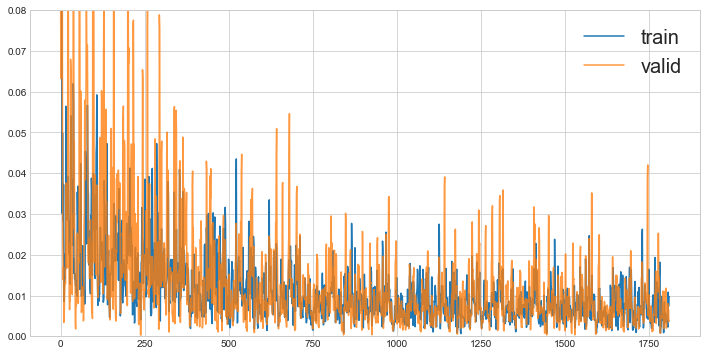

In [55]:
j = 1
scaler_dic = {}
all_history = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
for i in xrange(n_epochs):
  for name in service_name:
    values = data_set[name]
    train = values[:n_train, :]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    _ = scaler.fit_transform(train)
    scaled = scaler.fit_transform(values)
    scaler_dic[name] = scaler
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    #drop the employment column since we are not predicting number of employees a company has
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    print values.shape
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys 
    
    print name, train_X.shape, train_y.shape, test_X.shape, test_y.shape


    # fit network
    history = model.fit(train_X, train_y, epochs=2, batch_size=30, validation_data=(valid_X, valid_y), verbose=2, shuffle=False)
    all_history['loss'] += history.history['loss']
    all_history['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0, np.sum(all_history['val_loss'][-500:])
    
# plot all histories
plt.plot(all_history['loss'], label='train', alpha=1)
plt.plot(all_history['val_loss'], label='valid', alpha=0.8)
plt.ylim([0,.08])
plt.legend(fontsize=20)
plt.show()

## Fitting models and model comparison

### Train model with employment info

In [60]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model1.add(Dropout(0.25))

model1.add(LSTM(units=50))
model1.add(Dropout(0.25))

model1.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=optm)

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 2s 32ms/step - loss: 0.3164 - val_loss: 0.0220
Epoch 2/2
60/60 [==============================] - 0s 760us/step - loss: 0.2620 - val_loss: 0.0117
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 471us/step - loss: 0.2753 - val_loss: 0.2488
Epoch 2/2
60/60 [==============================] - 0s 638us/step - loss: 0.2238 - val_loss: 0.1746
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 462us/step - loss: 0.0718 - val_loss: 0.2748
Epoch 2/2
60/60 [==============================] - 0s 540us/step - loss: 0.0502 - val_loss: 0.1816
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 515us/step - loss: 0.0444 - val_loss: 0.0155
Epoch 2/2
60/60 [==============================] - 0s 566us/step - loss: 0.0362 - val_loss: 0.0177
Train on 60 samples, validate on 

60/60 [==============================] - 0s 491us/step - loss: 0.0227 - val_loss: 0.0321
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 446us/step - loss: 0.0106 - val_loss: 0.0087
Epoch 2/2
60/60 [==============================] - 0s 476us/step - loss: 0.0080 - val_loss: 0.0123
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 495us/step - loss: 0.0145 - val_loss: 0.0467
Epoch 2/2
60/60 [==============================] - 0s 451us/step - loss: 0.0168 - val_loss: 0.0496
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 419us/step - loss: 0.0190 - val_loss: 0.0434
Epoch 2/2
60/60 [==============================] - 0s 467us/step - loss: 0.0166 - val_loss: 0.0349
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 394us/step - loss: 0.0455 - val_loss: 0.0305
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 451us/step - loss: 0.0230 - val_loss: 0.0472
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 607us/step - loss: 0.0151 - val_loss: 0.0248
Epoch 2/2
60/60 [==============================] - 0s 463us/step - loss: 0.0128 - val_loss: 0.0240
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 448us/step - loss: 0.0098 - val_loss: 0.0222
Epoch 2/2
60/60 [==============================] - 0s 421us/step - loss: 0.0100 - val_loss: 0.0205
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - ETA: 0s - loss: 0.002 - 0s 501us/step - loss: 0.0095 - val_loss: 0.0038
Epoch 2/2
60/60 [==============================] - 0s 545us/step - loss: 0.0101 - val_loss: 0.0031
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 428us/step - loss: 0.0150 - val_loss: 0.0091
Epoch 2/

60/60 [==============================] - 0s 601us/step - loss: 0.0279 - val_loss: 0.0170
Epoch 2/2
60/60 [==============================] - 0s 503us/step - loss: 0.0327 - val_loss: 0.0165
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0145 - val_loss: 0.0322
Epoch 2/2
60/60 [==============================] - 0s 487us/step - loss: 0.0136 - val_loss: 0.0384
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 473us/step - loss: 0.0323 - val_loss: 0.0195
Epoch 2/2
60/60 [==============================] - 0s 505us/step - loss: 0.0351 - val_loss: 0.0208
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 408us/step - loss: 0.0265 - val_loss: 0.0172
Epoch 2/2
60/60 [==============================] - 0s 431us/step - loss: 0.0181 - val_loss: 0.0234
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 732us/step - loss: 0.0097 - val_loss: 0.0066
Epoch 2/2
60/60 [==============================] - 0s 494us/step - loss: 0.0076 - val_loss: 0.0061
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 541us/step - loss: 0.0319 - val_loss: 0.0241
Epoch 2/2
60/60 [==============================] - 0s 508us/step - loss: 0.0322 - val_loss: 0.0256
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 483us/step - loss: 0.0175 - val_loss: 0.0049
Epoch 2/2
60/60 [==============================] - 0s 476us/step - loss: 0.0166 - val_loss: 0.0042
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 529us/step - loss: 0.0062 - val_loss: 0.0383
Epoch 2/2
60/60 [==============================] - 0s 457us/step - loss: 0.0073 - val_loss: 0.0405
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 516us/step - loss: 0.0334 - val_loss: 0.0183
Epoch 2/2
60/60 [==============================] - 0s 520us/step - loss: 0.0347 - val_loss: 0.0169
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 436us/step - loss: 0.0118 - val_loss: 0.0063
Epoch 2/2
60/60 [==============================] - 0s 451us/step - loss: 0.0092 - val_loss: 0.0071
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 508us/step - loss: 0.0133 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 716us/step - loss: 0.0111 - val_loss: 0.0069
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 389us/step - loss: 0.0241 - val_loss: 0.0090
Epoch 2/2
60/60 [==============================] - 0s 654us/step - loss: 0.0215 - val_loss: 0.0079
Train on 60 samples, validate on

60/60 [==============================] - 0s 452us/step - loss: 0.0089 - val_loss: 0.0068
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 540us/step - loss: 0.0057 - val_loss: 0.0113
Epoch 2/2
60/60 [==============================] - 0s 548us/step - loss: 0.0046 - val_loss: 0.0108
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 464us/step - loss: 0.0095 - val_loss: 0.0064
Epoch 2/2
60/60 [==============================] - 0s 539us/step - loss: 0.0117 - val_loss: 0.0063
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 489us/step - loss: 0.0128 - val_loss: 0.0083
Epoch 2/2
60/60 [==============================] - 0s 491us/step - loss: 0.0096 - val_loss: 0.0057
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 489us/step - loss: 0.0116 - val_loss: 0.0070
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 465us/step - loss: 0.0123 - val_loss: 0.0085
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 398us/step - loss: 0.0169 - val_loss: 0.0090
Epoch 2/2
60/60 [==============================] - 0s 384us/step - loss: 0.0182 - val_loss: 0.0085
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 469us/step - loss: 0.0137 - val_loss: 0.0078
Epoch 2/2
60/60 [==============================] - 0s 591us/step - loss: 0.0133 - val_loss: 0.0058
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 482us/step - loss: 0.0102 - val_loss: 0.0059
Epoch 2/2
60/60 [==============================] - 0s 434us/step - loss: 0.0096 - val_loss: 0.0061
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 407us/step - loss: 0.0024 - val_loss: 0.0134
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 417us/step - loss: 0.0078 - val_loss: 0.0036
Epoch 2/2
60/60 [==============================] - 0s 428us/step - loss: 0.0050 - val_loss: 0.0034
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 438us/step - loss: 0.0206 - val_loss: 0.0038
Epoch 2/2
60/60 [==============================] - 0s 458us/step - loss: 0.0201 - val_loss: 0.0038
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 416us/step - loss: 0.0128 - val_loss: 0.0051
Epoch 2/2
60/60 [==============================] - 0s 488us/step - loss: 0.0097 - val_loss: 0.0060
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 380us/step - loss: 0.0057 - val_loss: 0.0083
Epoch 2/2
60/60 [==============================] - 0s 445us/step - loss: 0.0070 - val_loss: 0.0081
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 628us/step - loss: 0.0046 - val_loss: 0.0023
Epoch 2/2
60/60 [==============================] - 0s 496us/step - loss: 0.0070 - val_loss: 0.0022
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 568us/step - loss: 0.0131 - val_loss: 0.0112
Epoch 2/2
60/60 [==============================] - 0s 565us/step - loss: 0.0143 - val_loss: 0.0097
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 407us/step - loss: 0.0041 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 524us/step - loss: 0.0041 - val_loss: 0.0067
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 469us/step - loss: 0.0035 - val_loss: 0.0094
Epoch 2/2
60/60 [==============================] - 0s 778us/step - loss: 0.0026 - val_loss: 0.0074
Train on 60 samples, validate on

60/60 [==============================] - 0s 438us/step - loss: 0.0048 - val_loss: 0.0098
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 470us/step - loss: 0.0068 - val_loss: 0.0076
Epoch 2/2
60/60 [==============================] - 0s 483us/step - loss: 0.0050 - val_loss: 0.0051
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 486us/step - loss: 0.0147 - val_loss: 0.0153
Epoch 2/2
60/60 [==============================] - 0s 540us/step - loss: 0.0141 - val_loss: 0.0154
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 475us/step - loss: 0.0166 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.0171 - val_loss: 0.0083
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 503us/step - loss: 0.0091 - val_loss: 0.0100
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 391us/step - loss: 0.0112 - val_loss: 0.0093
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 401us/step - loss: 0.0044 - val_loss: 0.0012
Epoch 2/2
60/60 [==============================] - 0s 392us/step - loss: 0.0050 - val_loss: 0.0024
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 514us/step - loss: 0.0079 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 479us/step - loss: 0.0095 - val_loss: 0.0025
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 411us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 2/2
60/60 [==============================] - 0s 420us/step - loss: 0.0035 - val_loss: 0.0055
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 512us/step - loss: 0.0037 - val_loss: 0.0053
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 463us/step - loss: 0.0187 - val_loss: 0.0137
Epoch 2/2
60/60 [==============================] - 0s 437us/step - loss: 0.0176 - val_loss: 0.0151
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 472us/step - loss: 0.0095 - val_loss: 0.0037
Epoch 2/2
60/60 [==============================] - 0s 517us/step - loss: 0.0094 - val_loss: 0.0052
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 461us/step - loss: 0.0123 - val_loss: 0.0131
Epoch 2/2
60/60 [==============================] - 0s 507us/step - loss: 0.0125 - val_loss: 0.0141
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 481us/step - loss: 0.0097 - val_loss: 0.0146
Epoch 2/2
60/60 [==============================] - 0s 472us/step - loss: 0.0095 - val_loss: 0.0145
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 457us/step - loss: 0.0075 - val_loss: 9.2221e-04
Epoch 2/2
60/60 [==============================] - 0s 475us/step - loss: 0.0068 - val_loss: 8.8420e-04
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 397us/step - loss: 0.0049 - val_loss: 0.0109
Epoch 2/2
60/60 [==============================] - 0s 425us/step - loss: 0.0034 - val_loss: 0.0107
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 419us/step - loss: 0.0069 - val_loss: 0.0052
Epoch 2/2
60/60 [==============================] - 0s 461us/step - loss: 0.0073 - val_loss: 0.0037
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 440us/step - loss: 0.0112 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 409us/step - loss: 0.0099 - val_loss: 0.0052
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=================

60/60 [==============================] - 0s 524us/step - loss: 0.0067 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 449us/step - loss: 0.0101 - val_loss: 0.0067
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 404us/step - loss: 0.0125 - val_loss: 0.0025
Epoch 2/2
60/60 [==============================] - 0s 569us/step - loss: 0.0153 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 439us/step - loss: 0.0056 - val_loss: 0.0039
Epoch 2/2
60/60 [==============================] - 0s 431us/step - loss: 0.0079 - val_loss: 0.0039
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 521us/step - loss: 0.0073 - val_loss: 0.0084
Epoch 2/2
60/60 [==============================] - 0s 573us/step - loss: 0.0065 - val_loss: 0.0111
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 517us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 2/2
60/60 [==============================] - 0s 530us/step - loss: 0.0065 - val_loss: 0.0045
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 546us/step - loss: 0.0084 - val_loss: 0.0112
Epoch 2/2
60/60 [==============================] - 0s 516us/step - loss: 0.0093 - val_loss: 0.0111
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 501us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 557us/step - loss: 0.0031 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 468us/step - loss: 0.0068 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 592us/step - loss: 0.0098 - val_loss: 0.0085
Train on 60 samples, validate on

60/60 [==============================] - 0s 374us/step - loss: 0.0126 - val_loss: 0.0047
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 521us/step - loss: 0.0057 - val_loss: 0.0022
Epoch 2/2
60/60 [==============================] - 0s 445us/step - loss: 0.0057 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0023 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 439us/step - loss: 0.0022 - val_loss: 0.0094
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 397us/step - loss: 0.0095 - val_loss: 0.0073
Epoch 2/2
60/60 [==============================] - 0s 489us/step - loss: 0.0088 - val_loss: 0.0078
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 423us/step - loss: 0.0177 - val_loss: 0.0313
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 383us/step - loss: 0.0101 - val_loss: 0.0044
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 479us/step - loss: 0.0053 - val_loss: 0.0087
Epoch 2/2
60/60 [==============================] - 0s 713us/step - loss: 0.0053 - val_loss: 0.0085
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 500us/step - loss: 0.0062 - val_loss: 0.0025
Epoch 2/2
60/60 [==============================] - 0s 481us/step - loss: 0.0056 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 454us/step - loss: 0.0022 - val_loss: 0.0048
Epoch 2/2
60/60 [==============================] - 0s 462us/step - loss: 0.0030 - val_loss: 0.0048
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 419us/step - loss: 0.0077 - val_loss: 0.0027
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 539us/step - loss: 0.0031 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 575us/step - loss: 0.0038 - val_loss: 0.0031
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 400us/step - loss: 0.0018 - val_loss: 0.0029
Epoch 2/2
60/60 [==============================] - 0s 517us/step - loss: 0.0017 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 520us/step - loss: 0.0059 - val_loss: 0.0076
Epoch 2/2
60/60 [==============================] - 0s 533us/step - loss: 0.0069 - val_loss: 0.0074
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 400us/step - loss: 0.0051 - val_loss: 0.0028
Epoch 2/2
60/60 [==============================] - 0s 433us/step - loss: 0.0051 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 517us/step - loss: 0.0118 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 528us/step - loss: 0.0150 - val_loss: 0.0066
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 494us/step - loss: 0.0054 - val_loss: 0.0124
Epoch 2/2
60/60 [==============================] - 0s 457us/step - loss: 0.0081 - val_loss: 0.0128
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 551us/step - loss: 0.0115 - val_loss: 0.0102
Epoch 2/2
60/60 [==============================] - 0s 556us/step - loss: 0.0102 - val_loss: 0.0101
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 459us/step - loss: 0.0084 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0090 - val_loss: 0.0051
Train on 60 samples, validate on

60/60 [==============================] - 0s 560us/step - loss: 0.0077 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 491us/step - loss: 0.0045 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 533us/step - loss: 0.0042 - val_loss: 0.0030
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 415us/step - loss: 0.0019 - val_loss: 0.0032
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0023 - val_loss: 0.0033
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 470us/step - loss: 0.0054 - val_loss: 0.0072
Epoch 2/2
60/60 [==============================] - 0s 508us/step - loss: 0.0071 - val_loss: 0.0072
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 440us/step - loss: 0.0047 - val_loss: 0.0026
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - ETA: 0s - loss: 0.007 - 0s 554us/step - loss: 0.0086 - val_loss: 0.0129
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 443us/step - loss: 0.0064 - val_loss: 0.0123
Epoch 2/2
60/60 [==============================] - 0s 468us/step - loss: 0.0069 - val_loss: 0.0124
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 468us/step - loss: 0.0031 - val_loss: 0.0047
Epoch 2/2
60/60 [==============================] - 0s 422us/step - loss: 0.0028 - val_loss: 0.0056
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 448us/step - loss: 0.0072 - val_loss: 0.0020
Epoch 2/2
60/60 [==============================] - 0s 511us/step - loss: 0.0084 - val_loss: 0.0020
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 478us/step - loss: 0.0058 - val_loss: 0.0022
Epoch 2/

60/60 [==============================] - 0s 446us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 2/2
60/60 [==============================] - 0s 372us/step - loss: 0.0055 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 390us/step - loss: 0.0073 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 445us/step - loss: 0.0072 - val_loss: 0.0045
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - ETA: 0s - loss: 0.007 - 0s 345us/step - loss: 0.0059 - val_loss: 0.0028
Epoch 2/2
60/60 [==============================] - 0s 424us/step - loss: 0.0085 - val_loss: 0.0035
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 372us/step - loss: 0.0054 - val_loss: 0.0095
Epoch 2/2
60/60 [==============================] - 0s 421us/step - loss: 0.0043 - val_loss: 0.0094
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 456us/step - loss: 0.0063 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 423us/step - loss: 0.0080 - val_loss: 0.0042
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 414us/step - loss: 0.0062 - val_loss: 0.0083
Epoch 2/2
60/60 [==============================] - 0s 424us/step - loss: 0.0076 - val_loss: 0.0089
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 477us/step - loss: 0.0053 - val_loss: 0.0142
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0070 - val_loss: 0.0143
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 431us/step - loss: 0.0042 - val_loss: 0.0079
Epoch 2/2
60/60 [==============================] - 0s 602us/step - loss: 0.0029 - val_loss: 0.0082
Train on 60 samples, validate on

60/60 [==============================] - 0s 632us/step - loss: 0.0077 - val_loss: 0.0106
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 518us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 2/2
60/60 [==============================] - 0s 503us/step - loss: 0.0029 - val_loss: 0.0025
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 494us/step - loss: 0.0048 - val_loss: 0.0096
Epoch 2/2
60/60 [==============================] - 0s 416us/step - loss: 0.0060 - val_loss: 0.0091
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 477us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 494us/step - loss: 0.0044 - val_loss: 0.0051
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 530us/step - loss: 0.0038 - val_loss: 0.0028
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 487us/step - loss: 0.0019 - val_loss: 0.0111
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 485us/step - loss: 0.0100 - val_loss: 0.0069
Epoch 2/2
60/60 [==============================] - 0s 487us/step - loss: 0.0082 - val_loss: 0.0072
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 530us/step - loss: 0.0132 - val_loss: 0.0343
Epoch 2/2
60/60 [==============================] - 0s 538us/step - loss: 0.0150 - val_loss: 0.0345
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 423us/step - loss: 0.0043 - val_loss: 0.0026
Epoch 2/2
60/60 [==============================] - 0s 440us/step - loss: 0.0058 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 506us/step - loss: 0.0118 - val_loss: 0.0120
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 399us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 2/2
60/60 [==============================] - 0s 401us/step - loss: 0.0042 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 411us/step - loss: 0.0037 - val_loss: 0.0052
Epoch 2/2
60/60 [==============================] - 0s 444us/step - loss: 0.0027 - val_loss: 0.0050
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 424us/step - loss: 0.0076 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 496us/step - loss: 0.0075 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 560us/step - loss: 0.0067 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 549us/step - loss: 0.0081 - val_loss: 0.0039
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

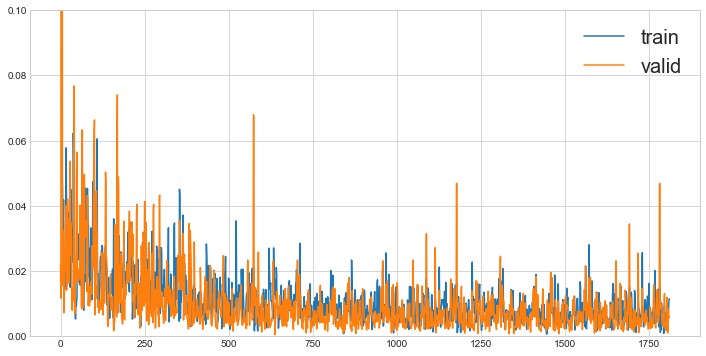

In [61]:
j = 1
scaler1_dic = {}
all_history1 = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
fnames = service_name
for i in xrange(n_epochs):
  #random.shuffle(fnames)
  for name in fnames:
    values = data_set[name]

    scaler1 = MinMaxScaler(feature_range=(0, 1))
    _ = scaler1.fit_transform(train)
    scaled = scaler1.fit_transform(values)
    scaler1_dic[name] = scaler1
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    #drop the employment column since we are not predicting number of employees a company has
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys

    j += 1

    # fit network
    history = model1.fit(ftrain_X, ftrain_y, epochs=2, batch_size=30, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    all_history1['loss'] += history.history['loss']
    all_history1['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0
# plot all histories
plt.plot(all_history1['loss'], label='train')
plt.plot(all_history1['val_loss'], label='test')
plt.ylim([0,.1])
plt.legend(fontsize=20)
plt.show()

### Train without employment info

In [63]:
#train with employment info
n_in = 5
n_train, n_valid = 50, 10
n_features = 2

model0 = Sequential()
model0.add(LSTM(50, return_sequences=True, input_shape=(n_in, n_features)))
model0.add(Dropout(0.25))

model0.add(LSTM(units=50))
model0.add(Dropout(0.25))

model0.add(Dense(1))
optm = optimizers.Adam(learning_rate=0.001)
model0.compile(loss='mean_squared_error', optimizer=optm)

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 2s 34ms/step - loss: 0.2703 - val_loss: 0.0153
Epoch 2/2
60/60 [==============================] - 0s 492us/step - loss: 0.2215 - val_loss: 0.0101
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 572us/step - loss: 0.2262 - val_loss: 0.2140
Epoch 2/2
60/60 [==============================] - 0s 669us/step - loss: 0.1751 - val_loss: 0.1559
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 450us/step - loss: 0.0607 - val_loss: 0.2226
Epoch 2/2
60/60 [==============================] - 0s 575us/step - loss: 0.0444 - val_loss: 0.1438
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 528us/step - loss: 0.0421 - val_loss: 0.0176
Epoch 2/2
60/60 [==============================] - 0s 438us/step - loss: 0.0325 - val_loss: 0.0140
Train on 60 samples, validate on 

60/60 [==============================] - 0s 490us/step - loss: 0.0220 - val_loss: 0.0420
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 463us/step - loss: 0.0090 - val_loss: 0.0132
Epoch 2/2
60/60 [==============================] - 0s 478us/step - loss: 0.0098 - val_loss: 0.0169
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 466us/step - loss: 0.0156 - val_loss: 0.0491
Epoch 2/2
60/60 [==============================] - 0s 439us/step - loss: 0.0180 - val_loss: 0.0497
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 482us/step - loss: 0.0168 - val_loss: 0.0299
Epoch 2/2
60/60 [==============================] - 0s 445us/step - loss: 0.0160 - val_loss: 0.0203
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 557us/step - loss: 0.0319 - val_loss: 0.0304
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 557us/step - loss: 0.0226 - val_loss: 0.0378
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 465us/step - loss: 0.0135 - val_loss: 0.0231
Epoch 2/2
60/60 [==============================] - 0s 462us/step - loss: 0.0130 - val_loss: 0.0230
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 441us/step - loss: 0.0122 - val_loss: 0.0197
Epoch 2/2
60/60 [==============================] - 0s 485us/step - loss: 0.0088 - val_loss: 0.0200
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 438us/step - loss: 0.0068 - val_loss: 0.0015
Epoch 2/2
60/60 [==============================] - 0s 578us/step - loss: 0.0075 - val_loss: 0.0013
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 526us/step - loss: 0.0157 - val_loss: 0.0123
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 420us/step - loss: 0.0289 - val_loss: 0.0171
Epoch 2/2
60/60 [==============================] - 0s 439us/step - loss: 0.0256 - val_loss: 0.0162
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 455us/step - loss: 0.0144 - val_loss: 0.0270
Epoch 2/2
60/60 [==============================] - 0s 528us/step - loss: 0.0129 - val_loss: 0.0324
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 473us/step - loss: 0.0315 - val_loss: 0.0170
Epoch 2/2
60/60 [==============================] - 0s 517us/step - loss: 0.0325 - val_loss: 0.0204
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0201 - val_loss: 0.0110
Epoch 2/2
60/60 [==============================] - 0s 531us/step - loss: 0.0237 - val_loss: 0.0141
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 501us/step - loss: 0.0087 - val_loss: 0.0162
Epoch 2/2
60/60 [==============================] - 0s 508us/step - loss: 0.0081 - val_loss: 0.0121
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 613us/step - loss: 0.0312 - val_loss: 0.0199
Epoch 2/2
60/60 [==============================] - 0s 516us/step - loss: 0.0291 - val_loss: 0.0220
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 517us/step - loss: 0.0113 - val_loss: 0.0034
Epoch 2/2
60/60 [==============================] - 0s 519us/step - loss: 0.0152 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 409us/step - loss: 0.0082 - val_loss: 0.0340
Epoch 2/2
60/60 [==============================] - 0s 608us/step - loss: 0.0093 - val_loss: 0.0322
Train on 60 samples, validate on

60/60 [==============================] - 0s 589us/step - loss: 0.0100 - val_loss: 0.0053
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 662us/step - loss: 0.0255 - val_loss: 0.0105
Epoch 2/2
60/60 [==============================] - 0s 568us/step - loss: 0.0249 - val_loss: 0.0101
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 527us/step - loss: 0.0078 - val_loss: 0.0058
Epoch 2/2
60/60 [==============================] - 0s 527us/step - loss: 0.0100 - val_loss: 0.0059
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 409us/step - loss: 0.0110 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 535us/step - loss: 0.0125 - val_loss: 0.0064
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 480us/step - loss: 0.0212 - val_loss: 0.0037
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 427us/step - loss: 0.0107 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 472us/step - loss: 0.0057 - val_loss: 0.0113
Epoch 2/2
60/60 [==============================] - 0s 460us/step - loss: 0.0042 - val_loss: 0.0105
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 433us/step - loss: 0.0127 - val_loss: 0.0067
Epoch 2/2
60/60 [==============================] - 0s 452us/step - loss: 0.0145 - val_loss: 0.0067
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 902us/step - loss: 0.0086 - val_loss: 0.0053
Epoch 2/2
60/60 [==============================] - 0s 639us/step - loss: 0.0131 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0116 - val_loss: 0.0068
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 709us/step - loss: 0.0134 - val_loss: 0.0123
Epoch 2/2
60/60 [==============================] - 0s 540us/step - loss: 0.0117 - val_loss: 0.0095
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 511us/step - loss: 0.0167 - val_loss: 0.0097
Epoch 2/2
60/60 [==============================] - 0s 605us/step - loss: 0.0168 - val_loss: 0.0088
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 566us/step - loss: 0.0081 - val_loss: 0.0059
Epoch 2/2
60/60 [==============================] - 0s 559us/step - loss: 0.0125 - val_loss: 0.0057
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 485us/step - loss: 0.0048 - val_loss: 0.0028
Epoch 2/2
60/60 [==============================] - 0s 459us/step - loss: 0.0047 - val_loss: 0.0030
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 557us/step - loss: 0.0053 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 531us/step - loss: 0.0051 - val_loss: 0.0034
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 487us/step - loss: 0.0142 - val_loss: 0.0036
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0188 - val_loss: 0.0036
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 480us/step - loss: 0.0076 - val_loss: 0.0049
Epoch 2/2
60/60 [==============================] - 0s 434us/step - loss: 0.0107 - val_loss: 0.0048
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 623us/step - loss: 0.0061 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 562us/step - loss: 0.0072 - val_loss: 0.0077
Train on 60 samples, validate on

60/60 [==============================] - 0s 503us/step - loss: 0.0057 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 499us/step - loss: 0.0061 - val_loss: 0.0027
Epoch 2/2
60/60 [==============================] - 0s 594us/step - loss: 0.0041 - val_loss: 0.0022
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 505us/step - loss: 0.0100 - val_loss: 0.0107
Epoch 2/2
60/60 [==============================] - 0s 573us/step - loss: 0.0103 - val_loss: 0.0103
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 518us/step - loss: 0.0029 - val_loss: 0.0020
Epoch 2/2
60/60 [==============================] - 0s 681us/step - loss: 0.0035 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 471us/step - loss: 0.0041 - val_loss: 0.0035
Epoch 2/2
60/60 [=========================

60/60 [==============================] - 0s 486us/step - loss: 0.0065 - val_loss: 0.0131
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0064 - val_loss: 0.0129
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 441us/step - loss: 0.0047 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 763us/step - loss: 0.0035 - val_loss: 0.0059
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 439us/step - loss: 0.0153 - val_loss: 0.0139
Epoch 2/2
60/60 [==============================] - 0s 489us/step - loss: 0.0153 - val_loss: 0.0140
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 422us/step - loss: 0.0141 - val_loss: 0.0084
Epoch 2/2
60/60 [==============================] - 0s 480us/step - loss: 0.0153 - val_loss: 0.0083
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 583us/step - loss: 0.0110 - val_loss: 0.0086
Epoch 2/2
60/60 [==============================] - 0s 653us/step - loss: 0.0127 - val_loss: 0.0096
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 498us/step - loss: 0.0030 - val_loss: 0.0010
Epoch 2/2
60/60 [==============================] - 0s 550us/step - loss: 0.0058 - val_loss: 0.0011
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 508us/step - loss: 0.0079 - val_loss: 0.0030
Epoch 2/2
60/60 [==============================] - 0s 517us/step - loss: 0.0043 - val_loss: 0.0029
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 429us/step - loss: 0.0052 - val_loss: 0.0039
Epoch 2/2
60/60 [==============================] - 0s 425us/step - loss: 0.0043 - val_loss: 0.0053
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 541us/step - loss: 0.0176 - val_loss: 0.0138
Epoch 2/2
60/60 [==============================] - 0s 467us/step - loss: 0.0168 - val_loss: 0.0150
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 382us/step - loss: 0.0116 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 648us/step - loss: 0.0088 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 538us/step - loss: 0.0114 - val_loss: 0.0131
Epoch 2/2
60/60 [==============================] - 0s 487us/step - loss: 0.0128 - val_loss: 0.0137
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 483us/step - loss: 0.0067 - val_loss: 0.0162
Epoch 2/2
60/60 [==============================] - 0s 463us/step - loss: 0.0091 - val_loss: 0.0163
Train on 60 samples, validate on

60/60 [==============================] - 0s 542us/step - loss: 0.0141 - val_loss: 0.0091
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 491us/step - loss: 0.0085 - val_loss: 0.0014
Epoch 2/2
60/60 [==============================] - 0s 496us/step - loss: 0.0088 - val_loss: 0.0012
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 504us/step - loss: 0.0027 - val_loss: 0.0098
Epoch 2/2
60/60 [==============================] - 0s 615us/step - loss: 0.0035 - val_loss: 0.0103
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 442us/step - loss: 0.0072 - val_loss: 0.0057
Epoch 2/2
60/60 [==============================] - 0s 454us/step - loss: 0.0079 - val_loss: 0.0040
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 501us/step - loss: 0.0097 - val_loss: 0.0046
Epoch 2/2
60/60 [=========================

Epoch 2/2
60/60 [==============================] - 0s 438us/step - loss: 0.0056 - val_loss: 0.0052
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 440us/step - loss: 0.0094 - val_loss: 0.0075
Epoch 2/2
60/60 [==============================] - 0s 368us/step - loss: 0.0067 - val_loss: 0.0069
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 397us/step - loss: 0.0115 - val_loss: 0.0021
Epoch 2/2
60/60 [==============================] - 0s 477us/step - loss: 0.0112 - val_loss: 0.0022
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 382us/step - loss: 0.0068 - val_loss: 0.0039
Epoch 2/2
60/60 [==============================] - 0s 429us/step - loss: 0.0062 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 396us/step - loss: 0.0059 - val_loss: 0.0081
Epoch 2/2
60/60 [===============

60/60 [==============================] - 0s 617us/step - loss: 0.0084 - val_loss: 0.0047
Epoch 2/2
60/60 [==============================] - 0s 955us/step - loss: 0.0075 - val_loss: 0.0046
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 578us/step - loss: 0.0076 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 652us/step - loss: 0.0057 - val_loss: 0.0042
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 388us/step - loss: 0.0066 - val_loss: 0.0104
Epoch 2/2
60/60 [==============================] - 0s 428us/step - loss: 0.0094 - val_loss: 0.0105
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 494us/step - loss: 0.0029 - val_loss: 0.0025
Epoch 2/2
60/60 [==============================] - 0s 557us/step - loss: 0.0035 - val_loss: 0.0026
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 535us/step - loss: 0.0103 - val_loss: 0.0073
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 495us/step - loss: 0.0094 - val_loss: 0.0047
Epoch 2/2
60/60 [==============================] - 0s 477us/step - loss: 0.0096 - val_loss: 0.0046
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - ETA: 0s - loss: 0.001 - 0s 515us/step - loss: 0.0041 - val_loss: 0.0019
Epoch 2/2
60/60 [==============================] - 0s 519us/step - loss: 0.0048 - val_loss: 0.0019
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 430us/step - loss: 0.0021 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 548us/step - loss: 0.0020 - val_loss: 0.0074
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 604us/step - loss: 0.0114 - val_loss: 0.0077
Epoch 2/2
60/60 [=

60/60 [==============================] - 0s 878us/step - loss: 0.0166 - val_loss: 0.0028
Epoch 2/2
60/60 [==============================] - 0s 734us/step - loss: 0.0132 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 507us/step - loss: 0.0069 - val_loss: 0.0043
Epoch 2/2
60/60 [==============================] - 0s 485us/step - loss: 0.0072 - val_loss: 0.0043
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 433us/step - loss: 0.0039 - val_loss: 0.0089
Epoch 2/2
60/60 [==============================] - 0s 447us/step - loss: 0.0043 - val_loss: 0.0091
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 464us/step - loss: 0.0057 - val_loss: 0.0024
Epoch 2/2
60/60 [==============================] - 0s 484us/step - loss: 0.0060 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 567us/step - loss: 0.0095 - val_loss: 0.0085
Epoch 2/2
60/60 [==============================] - 0s 464us/step - loss: 0.0110 - val_loss: 0.0084
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 479us/step - loss: 0.0031 - val_loss: 0.0023
Epoch 2/2
60/60 [==============================] - 0s 536us/step - loss: 0.0031 - val_loss: 0.0030
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 559us/step - loss: 0.0017 - val_loss: 0.0034
Epoch 2/2
60/60 [==============================] - 0s 545us/step - loss: 0.0020 - val_loss: 0.0038
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 500us/step - loss: 0.0066 - val_loss: 0.0078
Epoch 2/2
60/60 [==============================] - 0s 571us/step - loss: 0.0065 - val_loss: 0.0074
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 504us/step - loss: 0.0107 - val_loss: 0.0122
Epoch 2/2
60/60 [==============================] - 0s 562us/step - loss: 0.0123 - val_loss: 0.0126
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 659us/step - loss: 0.0127 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 554us/step - loss: 0.0130 - val_loss: 0.0068
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 457us/step - loss: 0.0085 - val_loss: 0.0115
Epoch 2/2
60/60 [==============================] - 0s 600us/step - loss: 0.0069 - val_loss: 0.0118
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 478us/step - loss: 0.0143 - val_loss: 0.0099
Epoch 2/2
60/60 [==============================] - 0s 465us/step - loss: 0.0136 - val_loss: 0.0096
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 363us/step - loss: 0.0072 - val_loss: 0.0033
Epoch 2/2
60/60 [==============================] - 0s 556us/step - loss: 0.0059 - val_loss: 0.0028
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 571us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 2/2
60/60 [==============================] - 0s 529us/step - loss: 0.0039 - val_loss: 0.0053
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 390us/step - loss: 0.0018 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 486us/step - loss: 0.0015 - val_loss: 0.0049
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 355us/step - loss: 0.0065 - val_loss: 0.0071
Epoch 2/2
60/60 [==============================] - 0s 473us/step - loss: 0.0073 - val_loss: 0.0071
Train on 60 samples, validate on

60/60 [==============================] - 0s 462us/step - loss: 0.0076 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 470us/step - loss: 0.0129 - val_loss: 0.0122
Epoch 2/2
60/60 [==============================] - 0s 510us/step - loss: 0.0121 - val_loss: 0.0126
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 409us/step - loss: 0.0073 - val_loss: 0.0131
Epoch 2/2
60/60 [==============================] - 0s 468us/step - loss: 0.0064 - val_loss: 0.0131
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 638us/step - loss: 0.0037 - val_loss: 0.0059
Epoch 2/2
60/60 [==============================] - 0s 611us/step - loss: 0.0029 - val_loss: 0.0078
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 754us/step - loss: 0.0091 - val_loss: 0.0022
Epoch 2/2
60/60 [=========================

60/60 [==============================] - 0s 548us/step - loss: 0.0024 - val_loss: 0.0076
Epoch 2/2
60/60 [==============================] - 0s 940us/step - loss: 0.0026 - val_loss: 0.0080
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 573us/step - loss: 0.0067 - val_loss: 0.0045
Epoch 2/2
60/60 [==============================] - 0s 565us/step - loss: 0.0051 - val_loss: 0.0034
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 512us/step - loss: 0.0073 - val_loss: 0.0042
Epoch 2/2
60/60 [==============================] - 0s 593us/step - loss: 0.0090 - val_loss: 0.0046
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 527us/step - loss: 0.0062 - val_loss: 0.0026
Epoch 2/2
60/60 [==============================] - 0s 567us/step - loss: 0.0064 - val_loss: 0.0027
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 421us/step - loss: 0.0124 - val_loss: 0.0020
Epoch 2/2
60/60 [==============================] - 0s 564us/step - loss: 0.0083 - val_loss: 0.0020
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 389us/step - loss: 0.0060 - val_loss: 0.0040
Epoch 2/2
60/60 [==============================] - 0s 641us/step - loss: 0.0043 - val_loss: 0.0041
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 598us/step - loss: 0.0059 - val_loss: 0.0072
Epoch 2/2
60/60 [==============================] - 0s 497us/step - loss: 0.0056 - val_loss: 0.0077
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 444us/step - loss: 0.0060 - val_loss: 0.0137
Epoch 2/2
60/60 [==============================] - 0s 413us/step - loss: 0.0052 - val_loss: 0.0138
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 462us/step - loss: 0.0059 - val_loss: 0.0097
Epoch 2/2
60/60 [==============================] - 0s 437us/step - loss: 0.0078 - val_loss: 0.0095
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 416us/step - loss: 0.0027 - val_loss: 0.0025
Epoch 2/2
60/60 [==============================] - 0s 565us/step - loss: 0.0028 - val_loss: 0.0025
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 718us/step - loss: 0.0048 - val_loss: 0.0105
Epoch 2/2
60/60 [==============================] - 0s 545us/step - loss: 0.0039 - val_loss: 0.0100
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 451us/step - loss: 0.0057 - val_loss: 0.0044
Epoch 2/2
60/60 [==============================] - 0s 466us/step - loss: 0.0040 - val_loss: 0.0050
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 529us/step - loss: 0.0026 - val_loss: 0.0065
Epoch 2/2
60/60 [==============================] - 0s 479us/step - loss: 0.0021 - val_loss: 0.0072
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 400us/step - loss: 0.0114 - val_loss: 0.0070
Epoch 2/2
60/60 [==============================] - 0s 423us/step - loss: 0.0102 - val_loss: 0.0069
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 431us/step - loss: 0.0147 - val_loss: 0.0328
Epoch 2/2
60/60 [==============================] - 0s 436us/step - loss: 0.0147 - val_loss: 0.0328
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 484us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 2/2
60/60 [==============================] - 0s 455us/step - loss: 0.0049 - val_loss: 0.0025
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

60/60 [==============================] - 0s 819us/step - loss: 0.0061 - val_loss: 0.0024
Epoch 2/2
60/60 [==============================] - 0s 464us/step - loss: 0.0044 - val_loss: 0.0024
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 488us/step - loss: 0.0028 - val_loss: 0.0059
Epoch 2/2
60/60 [==============================] - 0s 499us/step - loss: 0.0032 - val_loss: 0.0059
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 466us/step - loss: 0.0088 - val_loss: 0.0019
Epoch 2/2
60/60 [==============================] - 0s 652us/step - loss: 0.0072 - val_loss: 0.0020
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [==============================] - 0s 689us/step - loss: 0.0088 - val_loss: 0.0037
Epoch 2/2
60/60 [==============================] - 0s 674us/step - loss: 0.0090 - val_loss: 0.0038
Train on 60 samples, validate on 15 samples
Epoch 1/2
60/60 [=========================

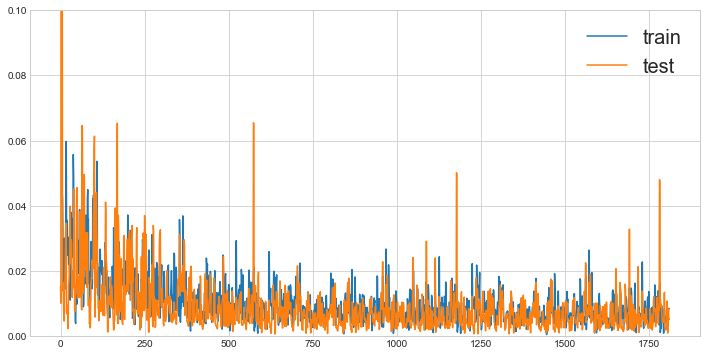

In [64]:
scaler0_dic = {}
all_history0 = {'loss':[], 'val_loss':[]}
n_epochs = 3
t0 = time.time()
fnames = service_name
for i in xrange(n_epochs):
  for name in fnames:
    values = data_set0[name]

    scaler0 = MinMaxScaler(feature_range=(0, 1))
    _ = scaler0.fit_transform(train)
    scaled = scaler0.fit_transform(values)
    scaler0_dic[name] = scaler0
    
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys

    # fit network
    history = model0.fit(ftrain_X, ftrain_y, epochs=2, batch_size=30, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    all_history0['loss'] += history.history['loss']
    all_history0['val_loss'] += history.history['val_loss']

print 'total train time: ', time.time()-t0
# plot all histories
plt.plot(all_history0['loss'], label='train0')
plt.plot(all_history0['val_loss'], label='test0')
plt.ylim([0,.1])
plt.legend(fontsize=20)
plt.show()

In [142]:
# save the trained models
pickle.dump([model1,scaler1_dic, all_history1, model0, scaler0_dic, all_history0], open( "model1_model0_serv.p", "wb" ) )
model1,scaler1_dic, all_history1, model0, scaler0_dic, all_history0 = pickle.load( open( "model1_model0_serv.p", "rb" ) )

In [159]:
def predict_y(modelx, name, dataset, sc_dic, n_in, n_train, n_valid):
    
    values = dataset[name]
    sc = sc_dic[name]
    scaled = sc.transform(values)
    res = series_to_supervised(scaled, n_in=n_in, n_out=1, dropnan=True)
    res.drop(res.columns[[n_in*2+1]], axis=1, inplace=True)
    
    values = res.values
    Xs, ys = split(values, n_in, n_train, n_valid)
    train_X, valid_X, test_X, ftrain_X = Xs
    train_y, valid_y, test_y, ftrain_y = ys
    
    yhat = modelx.predict(test_X)
    inv_yhat = sc.inverse_transform( np.concatenate((yhat, yhat), axis=1) )[:,0]

    y = test_y.reshape((len(test_y),1))
    inv_y = sc.inverse_transform( np.concatenate((y, y), axis=1) )[:,0]
    
    return y, yhat, inv_y, inv_yhat
    

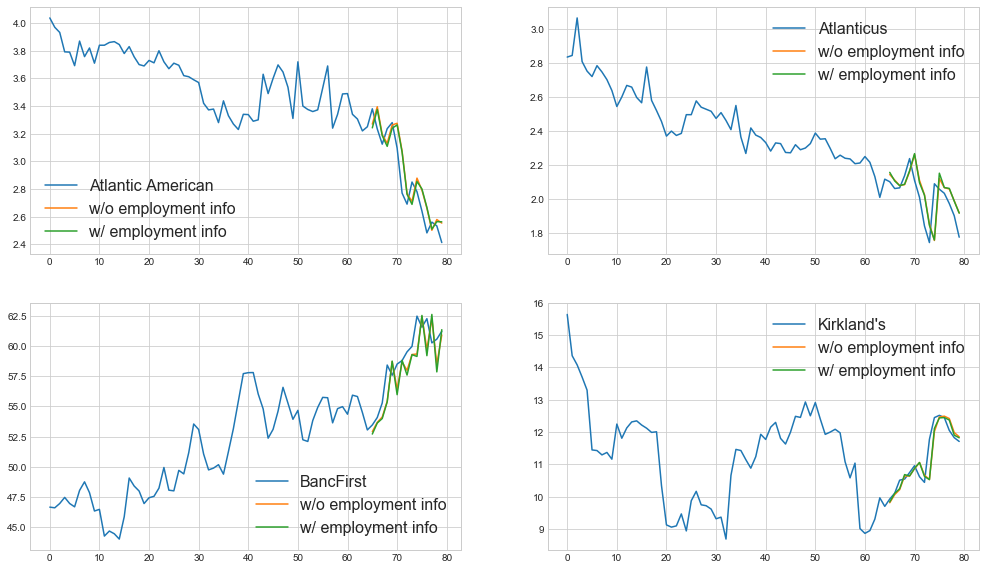

In [203]:
n_stock = 4
fnames = service_name[:]
random.shuffle(fnames)
fnames = fnames[:n_stock]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17,10))
axs = axs.flatten()
for i, name in enumerate(fnames):
    y0, yhat0, inv_y0, inv_yhat0 = predict_y(model0, name, data_set0, scaler0_dic, n_in, n_train, n_valid)
    y1, yhat1, inv_y1, inv_yhat1 = predict_y(model1, name, data_set, scaler1_dic, n_in, n_train, n_valid)
    
    y = data_set[name][:,0]
    x = range(len(y))
    
    axs[i].plot(x, y, label=name)
    axs[i].plot(x[-len(inv_yhat0):], inv_yhat0, label = 'w/o employment info')
    axs[i].plot(x[-len(inv_yhat1):], inv_yhat1, label = 'w/ employment info')
    axs[i].legend(fontsize=16)
    
plt.show()
    

In [162]:
# make a prediction
rms0, rms1 = [], []
for name in service_name:
    y0, yhat0, inv_y0, inv_yhat0 = predict_y(model0, name, data_set0, scaler0_dic, n_in, n_train, n_valid)
    y1, yhat1, inv_y1, inv_yhat1 = predict_y(model1, name, data_set, scaler1_dic, n_in, n_train, n_valid)
    
    rms0.append( np.sqrt(np.mean((y0-yhat0)**2)) )
    rms1.append( np.sqrt(np.mean((y1-yhat1)**2)) )

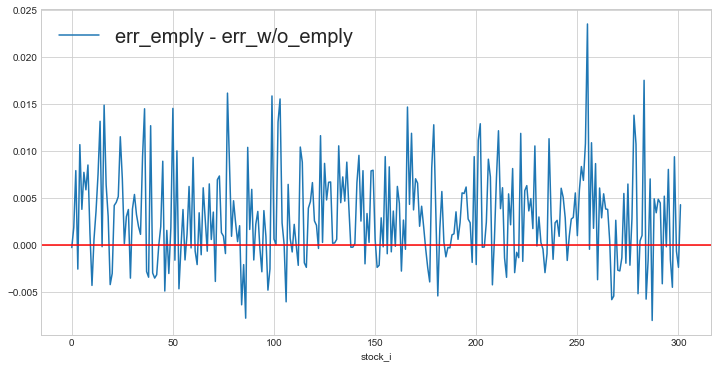

In [173]:
err_diff = [e1-e0 for e0,e1 in zip(rms0, rms1)]
plt.plot(err_diff, label='err_emply - err_w/o_emply')
plt.axhline(y=0., color='r', linestyle='-')
plt.xlabel('stock_i')
#plt.ylabel('rms_emply - rms_w/o_emply')
plt.legend(fontsize = 20)
plt.show()

### Take away:
1. Model fits better by split into industries, but still quite noisy.
2. Surprise: in service industry, including employment info lead to lower prediction accuracy!? More likely the model doesn't fit well for this combination of price+employment dataset.